# Assignment 7: Novelty Search
In our last assignment, we explored the idea of measuring diversity.  This week we'll turn it up to eleven, and directly incentivize diversity by playing around with novelty search.  

While not quite a deceptive landscape, we'll see how novelty search interacts with a rugged fitness landscape by revisiting our prior work on NK-landscapes from Assignment 3.  

In [1]:
# imports
import numpy as np
import copy
import matplotlib.pyplot as plt
plt.style.use('seaborn')

import scikits.bootstrap as bootstrap
import warnings
warnings.filterwarnings('ignore') # Danger, Will Robinson! (not a scalable hack, and may surpress other helpful warning other than for ill-conditioned bootstrapped CI distributions)

import scipy.stats # for finding statistical significance

import time

Our NK fitness landscape function from Assignment 3.  

In [2]:
class Landscape:
    """ N-K Fitness Landscape
    """

    
    def __init__(self, n=10, k=2):
        self.n = n # genome length
        self.k = k # number of other loci interacting with each gene
        self.gene_contribution_weight_matrix = np.random.rand(n,2**(k+1)) # for each gene, a lookup table for its fitness contribution, which depends on this gene's setting and also the setting of its interacting neighboring loci
        
    # find values of interacting loci
    def get_contributing_gene_values(self, genome, gene_num):     
        contributing_gene_values = ""
        for i in range(self.k+1): # for each interacing loci (including the location of this gene itself)
            contributing_gene_values += str(genome[(gene_num+i)%self.n]) # for simplicity we'll define the interacting genes as the ones immediately following the gene in question.  Get the values at each of these loci
        return contributing_gene_values # return the string containing the values of all loci which affect the fitness of this gene
    
    # find the value of a partiuclar genome
    def get_fitness(self, genome):
        gene_values = np.zeros(self.n) # the value of each gene in the genome
        for gene_num in range(len(genome)): # for each gene
            contributing_gene_values = self.get_contributing_gene_values(genome, gene_num) # get the values of the loci which affect it
            gene_values[gene_num] = self.gene_contribution_weight_matrix[gene_num,int(contributing_gene_values,2)] # use the values of the interacting loci (converted from a binary string to base-10 index) to find the lookup table entry for this combination of genome settings
        return np.mean(gene_values) # define the fitness of the full genome as the average of the contribution of its genes (and return it for use in the evolutionary algoirthm)

### Q1: Baseline implementation
Let's copy our usual `Individual` and `evolutionary_algorithm` setup from before.  For simplicity in future questions, let's simply our algorithm as much as possible, working with bit-string (as per the NK fitness function), mutation only (just flipping one bit) and no crossover, and simple truncation selection rather than tournament selection.  Like last week, let's also record genotypic diverity over time.

In [3]:
class Individual:
    
    def __init__(self, fitness_function, bit_string_length):
        self.genome = np.random.randint(2, size = bit_string_length)
        self.fitness_function = fitness_function
        self.fitness = 0
        
    def eval_fitness(self):
        self.fitness = self.fitness_function(self.genome)

In [4]:
def evolutionary_algorithm(fitness_function=None, total_generations=100, num_parents=10, num_children=10, bit_string_length=10, num_elements_to_mutate=1, crossover=True):
    """ Evolutinary Algorithm (copied from the basic hillclimber in our last assignment)
        
        parameters: 
        fitness_funciton: (callable function) that return the fitness of a genome 
                           given the genome as an input parameter (e.g. as defined in Landscape)
        total_generations: (int) number of total iterations for stopping condition
        num_parents: (int) the number of parents we downselect to at each generation (mu)
        num_childre: (int) the number of children (note: parents not included in this count) that we baloon to each generation (lambda)
        bit_string_length: (int) length of bit string genome to be evoloved
        num_elements_to_mutate: (int) number of alleles to modify during mutation (0 = no mutation)
        crossover (bool): whether to perform crossover when generating children 
        
        returns:
        fitness_over_time: (numpy array) track record of the top fitness value at each generation
    """

    # initialize record keeping
    solution = None # best genome so far
    solution_fitness = -99999 # fitness of best genome so far
    solution_generation = 0 # time (generations) when solution was found
    fitness_over_time = np.zeros(total_generations)
    solutions_over_time = np.zeros((total_generations,bit_string_length))
    diversity_over_time = np.zeros(total_generations)
    
    # the initialization proceedure
    population = [] # keep population of individuals in a list
    for i in range(num_parents): # only create parents for initialization (the mu in mu+lambda)
        population.append(Individual(fitness_function,bit_string_length)) # generate new random individuals as parents
    
    # get population fitness
    for i in range(len(population)):
        population[i].eval_fitness() # evaluate the fitness of each parent
    
    for generation_num in range(total_generations): # repeat
        
        # the modification procedure
        new_children = [] # keep children separate for now (lambda in mu+lambda)
        while len(new_children) < num_children:
            
            # inheretance
            [parent1, parent2] = np.random.choice(population, size=2) # pick 2 random parents
            child1 = copy.deepcopy(parent1) # initialize children as perfect copies of their parents
            child2 = copy.deepcopy(parent2)
            
            # crossover
#             if crossover:
#                 [crossover_point1, crossover_point2] = sorted(np.random.randint(0,bit_string_length,2)) # crossover points for 2-point crossover (sorted to make indexing easier in the next step)
#                 child1.genome[crossover_point1:crossover_point2+1] = parent2.genome[crossover_point1:crossover_point2+1] # take the point between the crossover points and swap in the genes from the other parent
#                 child2.genome[crossover_point1:crossover_point2+1] = parent1.genome[crossover_point1:crossover_point2+1]

            # mutation
            for this_child in [child1,child2]:
                elements_to_mutate = set()
                while len(elements_to_mutate)<num_elements_to_mutate:
                    elements_to_mutate.add(np.random.randint(bit_string_length)) # randomly select the location in the child bit string to mutate
                for this_element_to_mutate in elements_to_mutate:
                    this_child.genome[this_element_to_mutate] = (this_child.genome[this_element_to_mutate] + 1) % 2 # flip the bit at the chosen location
            
            new_children.extend((child1,child2)) # add children to the new_children list
            
        # the assessement procedure
        for i in range(len(new_children)):
            new_children[i].eval_fitness() # assign fitness to each child 

        # NOTE: recording keeping could be on just parents/survivors or whole population.  
        # By moving it up here above selection, we also include the children while record keeping
        # record keeping
        if population[0].fitness > solution_fitness: # if the new parent is the best found so far
            solution = population[0].genome                 # update best solution records
            solution_fitness = population[0].fitness
            solution_generation = generation_num
        fitness_over_time[generation_num] = solution_fitness # record the fitness of the current best over evolutionary time
        solutions_over_time[generation_num] = solution
        
        genome_list = np.array([individual.genome for individual in population])
        diversity = np.mean(genome_list.std(axis=0))
        diversity_over_time[generation_num] = diversity
        
            
        # selection procedure
        population += new_children # combine parents with new children (the + in mu+lambda)
        population = sorted(population, key=lambda individual: individual.fitness, reverse=True) # sort the full population by each individual's fitness (from highers to lowest)
        population = population[:num_parents] # perform truncation selection (keep just top mu individuals to become next set of parents)
        
    return fitness_over_time, solutions_over_time, diversity_over_time 

Initialize recordkeeping

In [5]:
experiment_results = {}
solutions_results = {}
diversity_results = {}

### Q1b: Baseline Results
Let's pull all the pieces together and run `20` repitions of `100` generations of a population with `20` parents and `20` children.  Let's use a NK-landscape with a bitstring length (`N`) of `15` and a highly rugged landscape of `K = 14`.  (My repitions take about 1.5 second each)

In [6]:
num_runs = 20
total_generations = 100
num_elements_to_mutate = 1
bit_string_length = 15
num_parents = 20
num_children = 20

n = bit_string_length
k = bit_string_length - 1

for run_name in ["fitness"]:
    experiment_results[run_name] = np.zeros((num_runs, total_generations))
    solutions_results[run_name] = np.zeros((num_runs, total_generations, bit_string_length))
    diversity_results[run_name] = np.zeros((num_runs, total_generations))
    for run_num in range(num_runs):
        start_time = time.time()
        landscape = Landscape(n=n, k=k) # generate a random fitness landscape with this level of ruggeddness
        fitness_over_time, solutions_over_time, diversity_over_time = evolutionary_algorithm(fitness_function=landscape.get_fitness, total_generations=total_generations, num_parents=num_parents, num_children=num_children, bit_string_length=bit_string_length, num_elements_to_mutate=1, crossover=False)   
        experiment_results[run_name][run_num] = fitness_over_time
        solutions_results[run_name][run_num] = solutions_over_time
        diversity_results[run_name][run_num] = diversity_over_time
        print(run_name,run_num,time.time()-start_time,experiment_results[run_name][run_num,-1])

fitness 0 1.62046480178833 0.7289238250144272
fitness 1 1.6651945114135742 0.7556486300514788
fitness 2 1.7679126262664795 0.7043953414840938
fitness 3 1.7688319683074951 0.6955059693664146
fitness 4 1.7960565090179443 0.6995191367996103
fitness 5 1.3574774265289307 0.6992618744489113
fitness 6 1.3358116149902344 0.6981808841196029
fitness 7 1.4895501136779785 0.7017584188633592
fitness 8 1.5224766731262207 0.7053958693283385
fitness 9 1.5604469776153564 0.7305436105682013
fitness 10 1.5351142883300781 0.6873269545529225
fitness 11 1.9682881832122803 0.6920888720844284
fitness 12 1.617950439453125 0.7088360372954104
fitness 13 1.7090575695037842 0.6868834560722731
fitness 14 1.4024412631988525 0.717348578283697
fitness 15 1.4841482639312744 0.7068107949010511
fitness 16 1.7315914630889893 0.782657220464688
fitness 17 1.5220396518707275 0.6772570006962463
fitness 18 1.6881976127624512 0.7113952788581758
fitness 19 1.415842056274414 0.7037362011497805


### Q1c: Plotting
Please plot both the fitness over time and diversity over time of this run.

plotting fitness
plotting fitness


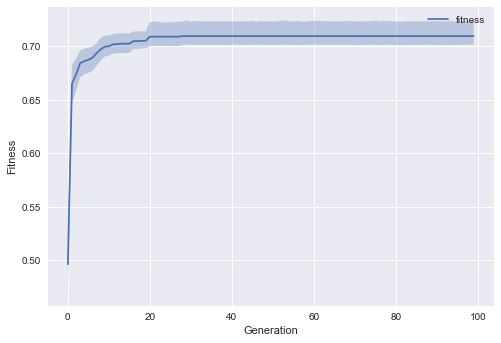

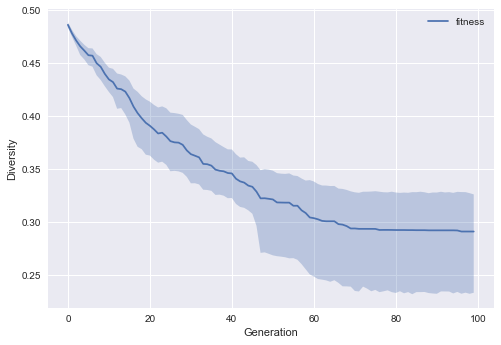

In [7]:
def plot_mean_and_bootstrapped_ci_over_time(input_data = None, name = "change me", x_label = "change me", y_label="change me", y_limit = None, plot_bootstrap = True):
    """
    
    parameters: 
    input_data: (numpy array of shape (max_k, num_repitions)) solution metric to plot
    name: (string) name for legend
    x_label: (string) x axis label
    y_label: (string) y axis label
    
    returns:
    None
    """

    fig, ax = plt.subplots() # generate figure and axes

    if isinstance(name, str): name = [name]; input_data = [input_data]

    # input_data = [fitness_over_time_mutation_only, fitness_over_time_crossover_only, fitness_over_time_mutation_and_crossover]
    # name = ["mutation_only", "crossover_only", "mutation_and_crossover"]

    # for this_input_data, this_name in zip(input_data, name):
    for this_name in name:
        print("plotting",this_name)
        this_input_data = input_data[this_name]
        total_generations = this_input_data.shape[1]

        if plot_bootstrap:
            boostrap_ci_generation_found = np.zeros((2,total_generations))
            for this_gen in range(total_generations):
                boostrap_ci_generation_found[:,this_gen] = bootstrap.ci(this_input_data[:,this_gen], np.mean, alpha=0.05)


        ax.plot(np.arange(total_generations), np.mean(this_input_data,axis=0), label = this_name) # plot the fitness over time
        if plot_bootstrap: ax.fill_between(np.arange(total_generations), boostrap_ci_generation_found[0,:], boostrap_ci_generation_found[1,:],alpha=0.3) # plot, and fill, the confidence interval for fitness over time
        ax.set_xlabel(x_label) # add axes labels
        ax.set_ylabel(y_label)
        if y_limit: ax.set_ylim(y_limit[0],y_limit[1])
        plt.legend(loc='best'); # add legend

plot_mean_and_bootstrapped_ci_over_time(input_data = experiment_results, name = ["fitness"], x_label = "Generation", y_label = "Fitness", plot_bootstrap = True)
plot_mean_and_bootstrapped_ci_over_time(input_data = diversity_results, name = ["fitness"], x_label = "Generation", y_label = "Diversity", plot_bootstrap = True)

### Q2: Analysis
What do your results look like?  In what ways, if any, do you expect that they'll change if we search for novelty instead of fitness?  Why?

**insert text here**

### Q3: Implementing Novelty
Let's implement novelty search! First, modify your `Individual` class to record `novelty` as an attribute (in additon to `fitness`).  

*Hint:* As ususal, you may want to skip ahead to the modification of your `evolutionary_algorithm` function in `Q4` and come back to fill in the helper functions in `Q3` once you have a better idea of when they'll be used (they just appear first to establish defniitions in case you `Restart and Run All`).

In [8]:
class Individual:
    
    def __init__(self, fitness_function, bit_string_length):
        self.genome = np.random.randint(2, size = bit_string_length)
        self.fitness_function = fitness_function
        self.fitness = 0
        self.novelty = 0
        
    def eval_fitness(self):
        self.fitness = self.fitness_function(self.genome)

### Q3b: Caclulate Novelty
Let's define the novelty of a solution to be the average hamming/euclidean distance (i.e. number of differing bits) between the closest `k` genomes to it within an archive of prior solutions.  It may be helpful to define a helper function to calculate this quanity.  

In [9]:
def get_novelty(solution_archive, individual, k):
    
    archive_size = len(solution_archive)
    
    if archive_size < k: k = archive_size-1
    distance_to_new_genome = np.zeros(archive_size)
    for i in range(archive_size):
        distance_to_new_genome[i] = np.sum(np.abs(solution_archive[i].genome - individual.genome))
    distance_to_new_genome = sorted(distance_to_new_genome)
#     print(distance_to_new_genome[1:k+1])
#     print("novelty:", np.mean(distance_to_new_genome[1:k+1]))
    return np.mean(distance_to_new_genome[1:k+1])

### Q3c:  Selecting for Novelty
Please modify your evolutionary algorithm code to select (again, using the truncation selection as above) for the most novel solutions in our population (according to the novelty metric defined above), regardless of their fitness.  

In order to keep down the cost of computing the distance between a new genome and all those that have previously existed, let's also set a finite size to our novelty archive (as a parameter we can pass to the algorithm).  When we trying to add new genomes to the novelty archive, only add the the new individual if it has a higher novelty score than an individual already in the novelty archive (and remove that prior individual from the archive to keeep the archive size the same).  Let's also say that the novelty of an individual will be its novelty score when first being considered for additon to the archive (i.e. we do not have to re-calculate it in the future as the makeup of the archive changes).

It may also be helpful to build a helper function for (potentially) updating the archive with a new individual.

Feel free to use the indidivuals in the current generation for your archive calculation or not, whichever is more convenient for your implementation.  

*Hint:* If you've sorted the population by novelty for selection, don't forget that the population will no longer be in order of fitness when you go to record the fitness of most fit indidivual for record keeping!

In [20]:
def update_archive(solution_archive, individual, max_archive_length):
    
    solution_archive = sorted(solution_archive, key=lambda individual: individual.novelty)
#     print ([i.novelty for i in solution_archive[0:5]])
    
    if len(solution_archive) < max_archive_length:
        solution_archive.append(individual)
    elif solution_archive[0].novelty < individual.novelty:
        solution_archive.pop(0)
        solution_archive.append(individual)
    return solution_archive

In [21]:
def evolutionary_algorithm(fitness_function=None, total_generations=100, num_parents=10, num_children=10, bit_string_length=10, num_elements_to_mutate=1, crossover=True, novelty_k = 0, max_archive_length = 100):
    """ Evolutinary Algorithm (copied from the basic hillclimber in our last assignment)
        
        parameters: 
        fitness_funciton: (callable function) that return the fitness of a genome 
                           given the genome as an input parameter (e.g. as defined in Landscape)
        total_generations: (int) number of total iterations for stopping condition
        num_parents: (int) the number of parents we downselect to at each generation (mu)
        num_childre: (int) the number of children (note: parents not included in this count) that we baloon to each generation (lambda)
        bit_string_length: (int) length of bit string genome to be evoloved
        num_elements_to_mutate: (int) number of alleles to modify during mutation (0 = no mutation)
        crossover (bool): whether to perform crossover when generating children 
        
        returns:
        fitness_over_time: (numpy array) track record of the top fitness value at each generation
    """

    # initialize record keeping
    solution = None # best genome so far
    solution_fitness = -99999 # fitness of best genome so far
    solution_generation = 0 # time (generations) when solution was found
    fitness_over_time = np.zeros(total_generations)
    solution_archive = []
    
    # the initialization proceedure
    population = [] # keep population of individuals in a list
    for i in range(num_parents): # only create parents for initialization (the mu in mu+lambda)
        population.append(Individual(fitness_function,bit_string_length)) # generate new random individuals as parents
    
    # get population fitness
    for i in range(len(population)):
        population[i].eval_fitness() # evaluate the fitness of each parent
        
    for i in range(len(population)):
        solution_archive.append(population[i])
    
    for generation_num in range(total_generations): # repeat
        
        # the modification procedure
        new_children = [] # keep children separate for now (lambda in mu+lambda)
        while len(new_children) < num_children:
            
            # inheretance
            [parent1, parent2] = np.random.choice(population, size=2) # pick 2 random parents
            child1 = copy.deepcopy(parent1) # initialize children as perfect copies of their parents
            child2 = copy.deepcopy(parent2)
            
#             # crossover
#             if crossover:
#                 [crossover_point1, crossover_point2] = sorted(np.random.randint(0,bit_string_length,2)) # crossover points for 2-point crossover (sorted to make indexing easier in the next step)
#                 child1.genome[crossover_point1:crossover_point2+1] = parent2.genome[crossover_point1:crossover_point2+1] # take the point between the crossover points and swap in the genes from the other parent
#                 child2.genome[crossover_point1:crossover_point2+1] = parent1.genome[crossover_point1:crossover_point2+1]

            # mutation
            for this_child in [child1,child2]:
                elements_to_mutate = set()
                while len(elements_to_mutate)<num_elements_to_mutate:
                    elements_to_mutate.add(np.random.randint(bit_string_length)) # randomly select the location in the child bit string to mutate
                for this_element_to_mutate in elements_to_mutate:
                    this_child.genome[this_element_to_mutate] = (this_child.genome[this_element_to_mutate] + 1) % 2 # flip the bit at the chosen location
            
            new_children.extend((child1,child2)) # add children to the new_children list
        
        
#         for i in range(len(new_children)):
#             solution_archive.append(new_children[i].genome)
#         solution_archive = solution_archive[:max_archive_length]
            
        # the assessement procedure
        for i in range(len(new_children)):
            new_children[i].eval_fitness() # assign fitness to each child 

        for i in range(len(new_children)):
            new_children[i].novelty = get_novelty(solution_archive, new_children[i], novelty_k) # assign fitness to each child            
            solution_archive = update_archive(solution_archive, new_children[i], max_archive_length)
            
        # NOTE: recording keeping could be on just parents/survivors or whole population.  
        # By moving it up here above selection, we also include the children while record keeping
        # record keeping
        population = sorted(population, key=lambda individual: individual.fitness, reverse=True) # sort the full population by each individual's fitness (from highers to lowest)
        if population[0].fitness > solution_fitness: # if the new parent is the best found so far
            solution = population[0].genome                 # update best solution records
            solution_fitness = population[0].fitness
            solution_generation = generation_num
        fitness_over_time[generation_num] = solution_fitness # record the fitness of the current best over evolutionary time
        solutions_over_time[generation_num] = solution
        
        genome_list = np.array([individual.genome for individual in population])
        diversity = np.mean(genome_list.std(axis=0))
        diversity_over_time[generation_num] = diversity    
            
        # selection procedure
        population += new_children # combine parents with new children (the + in mu+lambda)
        population = sorted(population, key=lambda individual: individual.fitness, reverse=True) # sort the full population by each individual's fitness (from highers to lowest)
        if novelty_k > 0: population = sorted(population, key=lambda individual: individual.novelty, reverse=True) # sort the full population by each individual's fitness (from highers to lowest)
        population = population[:num_parents] # perform truncation selection (keep just top mu individuals to become next set of parents)
        
    return fitness_over_time, solutions_over_time, diversity_over_time 

### Q4: Run
Run novelty search with the same hyperparameter settings as above, and with a `novelty_k` value of `5` nearest neighbors for calculating the novelty metrics, from an archive of the `100` most novel individuals found thus far.  (My runs take about 3 seconds for each repitition)

In [22]:
num_runs = 20
total_generations = 100
num_elements_to_mutate = 1
bit_string_length = 15
num_parents = 20
num_children = 20
novelty_k = 5
max_archive_length = 100

n = bit_string_length
k = bit_string_length-1

for run_name in ["novelty_5"]:    
    experiment_results[run_name] = np.zeros((num_runs, total_generations))
    solutions_results[run_name] = np.zeros((num_runs, total_generations, bit_string_length))
    diversity_results[run_name] = np.zeros((num_runs, total_generations))
    for run_num in range(num_runs):
        start_time = time.time()
        landscape = Landscape(n=n, k=k) # generate a random fitness landscape with this level of ruggeddness
        fitness_over_time, solutions_over_time, diversity_over_time = evolutionary_algorithm(fitness_function=landscape.get_fitness, total_generations=total_generations, num_parents=num_parents, num_children=num_children, bit_string_length=bit_string_length, num_elements_to_mutate=1, crossover=False, novelty_k = novelty_k, max_archive_length=max_archive_length)   
        experiment_results[run_name][run_num] = fitness_over_time
        solutions_results[run_name][run_num] = solutions_over_time
        diversity_results[run_name][run_num] = diversity_over_time
        print(run_name,run_num,time.time()-start_time,experiment_results[run_name][run_num,-1])

novelty_5 0 2.3557841777801514 0.7133865112719265
novelty_5 1 2.3533518314361572 0.6558775563519342
novelty_5 2 2.424057722091675 0.643574535411234
novelty_5 3 2.3905930519104004 0.6449927493928234
novelty_5 4 2.3530755043029785 0.659328208204035
novelty_5 5 2.425910234451294 0.6502145378353196
novelty_5 6 2.501671552658081 0.6643752785376482
novelty_5 7 2.4620096683502197 0.6521623618820825
novelty_5 8 2.5063250064849854 0.6760547792487858
novelty_5 9 2.587268352508545 0.6221602896140513
novelty_5 10 2.398460626602173 0.7544815820750436
novelty_5 11 2.5864510536193848 0.6561946471579001
novelty_5 12 2.4971024990081787 0.6429456985503859
novelty_5 13 2.456157684326172 0.69101162720156
novelty_5 14 2.430544376373291 0.618743260666965
novelty_5 15 2.5348868370056152 0.7226163690988469
novelty_5 16 2.4551985263824463 0.6775027892031207
novelty_5 17 2.471158027648926 0.6252356925822838
novelty_5 18 2.5960657596588135 0.686405572964789
novelty_5 19 2.8666932582855225 0.6726094169856742


### Q4b: Plot
Please visualize the fitness and diversity over time for novelty search vs. fitness-based search

plotting fitness
plotting novelty_5
plotting fitness
plotting novelty_5


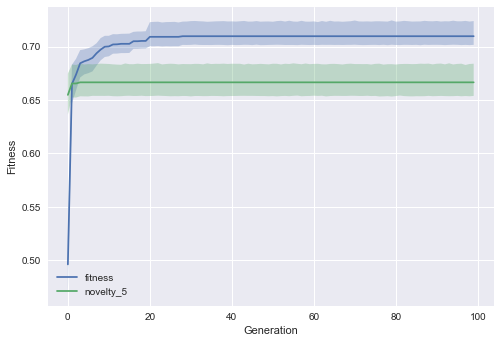

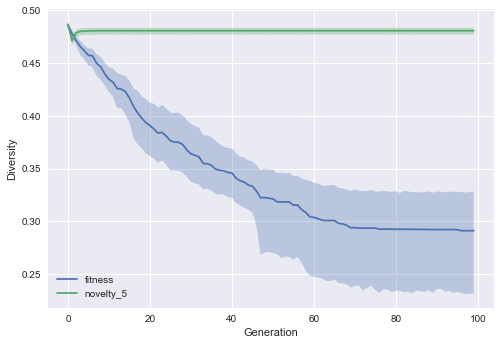

In [23]:
run_names = ["fitness", "novelty_5"]

plot_mean_and_bootstrapped_ci_over_time(input_data = experiment_results, name = run_names, x_label = "Generation", y_label = "Fitness", plot_bootstrap = True)
plot_mean_and_bootstrapped_ci_over_time(input_data = diversity_results, name = run_names, x_label = "Generation", y_label = "Diversity", plot_bootstrap = True)

### Q5: Analysis
How does novelty search perform in this domain?  Is it what you expected?  If no, why might that be the case?

**insert text here**

### Q6: Larger Neighborhoods
How might you expect the result to change if you were to use a larger neighborhood (`novelty_k` value) for calculating a soluton's novelty.  

Let's try it!  Please run and plot the same settings as above, but with a `novelty_k` of `100` (i.e. using the full archive for novelty calcuation).

In [24]:
num_runs = 20
total_generations = 100
num_elements_to_mutate = 1
bit_string_length = 15
num_parents = 20
num_children = 20
novelty_k = 100
max_archive_length = 100

n = bit_string_length
k = bit_string_length-1

for run_name in ["novelty_100"]:    
    experiment_results[run_name] = np.zeros((num_runs, total_generations))
    solutions_results[run_name] = np.zeros((num_runs, total_generations, bit_string_length))
    diversity_results[run_name] = np.zeros((num_runs, total_generations))
    for run_num in range(num_runs):
        start_time = time.time()
        landscape = Landscape(n=n, k=k) # generate a random fitness landscape with this level of ruggeddness
        fitness_over_time, solutions_over_time, diversity_over_time = evolutionary_algorithm(fitness_function=landscape.get_fitness, total_generations=total_generations, num_parents=num_parents, num_children=num_children, bit_string_length=bit_string_length, num_elements_to_mutate=1, crossover=False, novelty_k = novelty_k, max_archive_length = max_archive_length)   
        experiment_results[run_name][run_num] = fitness_over_time
        solutions_results[run_name][run_num] = solutions_over_time
        diversity_results[run_name][run_num] = diversity_over_time
        print(run_name,run_num,time.time()-start_time,experiment_results[run_name][run_num,-1])

novelty_100 0 2.4372010231018066 0.6267189857516198
novelty_100 1 2.418207883834839 0.6786159463090707
novelty_100 2 2.4352118968963623 0.7517561278919074
novelty_100 3 2.390871524810791 0.6413328397438609
novelty_100 4 2.3657822608947754 0.6703416047077287
novelty_100 5 2.3477976322174072 0.7597234825332546
novelty_100 6 2.368927240371704 0.6673412067575053
novelty_100 7 2.3614490032196045 0.6479034406748286
novelty_100 8 2.485168933868408 0.700425574934053
novelty_100 9 2.3464601039886475 0.6667701319825542
novelty_100 10 2.378025770187378 0.628583058334114
novelty_100 11 2.4161815643310547 0.6873580145823293
novelty_100 12 2.379206657409668 0.6974945045181636
novelty_100 13 2.319689989089966 0.6585480631573489
novelty_100 14 2.311490058898926 0.6998570064308786
novelty_100 15 2.3480722904205322 0.6723091373327067
novelty_100 16 2.3299262523651123 0.7274649308803431
novelty_100 17 2.341876983642578 0.7116055024924495
novelty_100 18 2.352475881576538 0.671173238381993
novelty_100 19 2

plotting fitness
plotting novelty_5
plotting novelty_100
plotting fitness
plotting novelty_5
plotting novelty_100


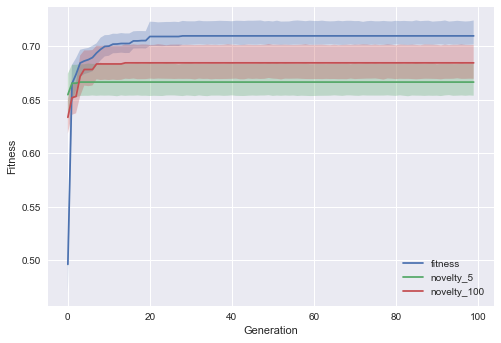

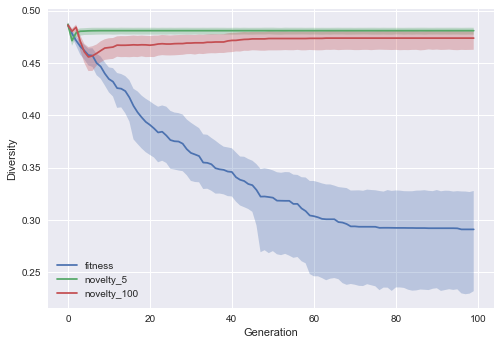

In [25]:
run_names = ["fitness", "novelty_5", "novelty_100"]

plot_mean_and_bootstrapped_ci_over_time(input_data = experiment_results, name = run_names, x_label = "Generation", y_label = "Fitness", plot_bootstrap = True)
plot_mean_and_bootstrapped_ci_over_time(input_data = diversity_results, name = run_names, x_label = "Generation", y_label = "Diversity", plot_bootstrap = True)

### Q6b: Analysis
What happened?  Did it work better or worse?  Is this what you expected (and why)?

**insert text here**

### Q7: Mixed Fitness and Novelty
As suggested in class, perhaps the best version of an evolutionary algorithm is not one that selects just for fitness or one that selects just for novelty, but one that considers both in an attempt to carefully tradeoff exploration and exploitation. 

We may not be the most careful and inentional with our tradeoffs here, but let's start with perhaps the simplest combination of selecting for both novelty and fitness one could think of.  Let's select some of the individuals in our population on the basis of novelty and some on the basis of fitness.  

In particular, pleae define a new parameter `novelty_selection_prop` that defines what proportion of the parents for the next generation will be selected by novelty (and choose the most novel solutions to occupy that portion of the new generation) while the remainder of the new population (`1-novelty_selection_prop`) gets selected on the basis of fitness -- resulting in the same `num_parents` as before heading into the next generation.  

In [26]:
def evolutionary_algorithm(fitness_function=None, total_generations=100, num_parents=10, num_children=10, bit_string_length=10, num_elements_to_mutate=1, crossover=True, novelty_k = 0, novelty_selection_prop = 0, max_archive_length = 100):
    """ Evolutinary Algorithm (copied from the basic hillclimber in our last assignment)
        
        parameters: 
        fitness_funciton: (callable function) that return the fitness of a genome 
                           given the genome as an input parameter (e.g. as defined in Landscape)
        total_generations: (int) number of total iterations for stopping condition
        num_parents: (int) the number of parents we downselect to at each generation (mu)
        num_childre: (int) the number of children (note: parents not included in this count) that we baloon to each generation (lambda)
        bit_string_length: (int) length of bit string genome to be evoloved
        num_elements_to_mutate: (int) number of alleles to modify during mutation (0 = no mutation)
        crossover (bool): whether to perform crossover when generating children 
        
        returns:
        fitness_over_time: (numpy array) track record of the top fitness value at each generation
    """

    # initialize record keeping
    solution = None # best genome so far
    solution_fitness = -99999 # fitness of best genome so far
    solution_generation = 0 # time (generations) when solution was found
    fitness_over_time = np.zeros(total_generations)
    solution_archive = []
    
    # the initialization proceedure
    population = [] # keep population of individuals in a list
    for i in range(num_parents): # only create parents for initialization (the mu in mu+lambda)
        population.append(Individual(fitness_function,bit_string_length)) # generate new random individuals as parents
    
    # get population fitness
    for i in range(len(population)):
        population[i].eval_fitness() # evaluate the fitness of each parent
        
    for i in range(len(population)):
        solution_archive.append(population[i])
    
    for generation_num in range(total_generations): # repeat
        
        # the modification procedure
        new_children = [] # keep children separate for now (lambda in mu+lambda)
        while len(new_children) < num_children:
            
            # inheretance
            [parent1, parent2] = np.random.choice(population, size=2) # pick 2 random parents
            child1 = copy.deepcopy(parent1) # initialize children as perfect copies of their parents
            child2 = copy.deepcopy(parent2)
            
#             # crossover
#             if crossover:
#                 [crossover_point1, crossover_point2] = sorted(np.random.randint(0,bit_string_length,2)) # crossover points for 2-point crossover (sorted to make indexing easier in the next step)
#                 child1.genome[crossover_point1:crossover_point2+1] = parent2.genome[crossover_point1:crossover_point2+1] # take the point between the crossover points and swap in the genes from the other parent
#                 child2.genome[crossover_point1:crossover_point2+1] = parent1.genome[crossover_point1:crossover_point2+1]

            # mutation
            for this_child in [child1,child2]:
                elements_to_mutate = set()
                while len(elements_to_mutate)<num_elements_to_mutate:
                    elements_to_mutate.add(np.random.randint(bit_string_length)) # randomly select the location in the child bit string to mutate
                for this_element_to_mutate in elements_to_mutate:
                    this_child.genome[this_element_to_mutate] = (this_child.genome[this_element_to_mutate] + 1) % 2 # flip the bit at the chosen location
            
            new_children.extend((child1,child2)) # add children to the new_children list
        
        
#         for i in range(len(new_children)):
#             solution_archive.append(new_children[i].genome)
#         solution_archive = solution_archive[:max_archive_length]
            
        # the assessement procedure
        for i in range(len(new_children)):
            new_children[i].eval_fitness() # assign fitness to each child 

        for i in range(len(new_children)):
            new_children[i].novelty = get_novelty(solution_archive, new_children[i], novelty_k) # assign fitness to each child            
            solution_archive = update_archive(solution_archive, new_children[i], max_archive_length)
            
        # NOTE: recording keeping could be on just parents/survivors or whole population.  
        # By moving it up here above selection, we also include the children while record keeping
        # record keeping
        population = sorted(population, key=lambda individual: individual.fitness, reverse=True) # sort the full population by each individual's fitness (from highers to lowest)
        if population[0].fitness > solution_fitness: # if the new parent is the best found so far
            solution = population[0].genome                 # update best solution records
            solution_fitness = population[0].fitness
            solution_generation = generation_num
        fitness_over_time[generation_num] = solution_fitness # record the fitness of the current best over evolutionary time
        solutions_over_time[generation_num] = solution
        
        genome_list = np.array([individual.genome for individual in population])
        diversity = np.mean(genome_list.std(axis=0))
        diversity_over_time[generation_num] = diversity
            
        # selection procedure
        population += new_children # combine parents with new children (the + in mu+lambda)
        population = sorted(population, key=lambda individual: individual.fitness, reverse=True) # sort the full population by each individual's fitness (from highers to lowest)
        new_population = population[:int(num_parents*(1-novelty_selection_prop))] # perform truncation selection (keep just top mu individuals to become next set of parents)
        
        population = sorted(population, key=lambda individual: individual.novelty, reverse=True) # sort the full population by each individual's fitness (from highers to lowest)
        while len(new_population) < num_parents:
#             print("adding novelty")
            this_ind = population.pop()
            if not this_ind in new_population:
                new_population.append(this_ind)

        
    return fitness_over_time, solutions_over_time, diversity_over_time 

### Q8: Experimentation
Let's try running this mixed selection criteria for a 50/50 split between suvivors/parents for the next generation selected via novelty vs. fitness.  Let's do this with our original novelty neighbhorhood of size 5, and all other parameters the same.  

As usual, please plot fitness and diversity afterwards.

In [27]:
num_runs = 20
total_generations = 100
num_elements_to_mutate = 1
bit_string_length = 15
num_parents = 20
num_children = 20

novelty_k = 5
novelty_selection_prop = 0.5
max_archive_length = 100

n = bit_string_length
k = bit_string_length-1

for run_name in ["fitness_and_novelty_5_novelty_prop_0.5"]:
    experiment_results[run_name] = np.zeros((num_runs, total_generations))
    solutions_results[run_name] = np.zeros((num_runs, total_generations, bit_string_length))
    diversity_results[run_name] = np.zeros((num_runs, total_generations))
    for run_num in range(num_runs):
        start_time = time.time()
        landscape = Landscape(n=n, k=k) # generate a random fitness landscape with this level of ruggeddness
        fitness_over_time, solutions_over_time, diversity_over_time = evolutionary_algorithm(fitness_function=landscape.get_fitness, total_generations=total_generations, num_parents=num_parents, num_children=num_children, bit_string_length=bit_string_length, num_elements_to_mutate=1, crossover=False, novelty_k = novelty_k, novelty_selection_prop = novelty_selection_prop, max_archive_length = max_archive_length)   
        experiment_results[run_name][run_num] = fitness_over_time
        solutions_results[run_name][run_num] = solutions_over_time
        diversity_results[run_name][run_num] = diversity_over_time
        print(run_name,run_num,time.time()-start_time,experiment_results[run_name][run_num,-1])

fitness_and_novelty_5_novelty_prop_0.5 0 3.834580183029175 0.7401055579568286
fitness_and_novelty_5_novelty_prop_0.5 1 3.841020345687866 0.7495613749435044
fitness_and_novelty_5_novelty_prop_0.5 2 3.8157355785369873 0.7207328904490241
fitness_and_novelty_5_novelty_prop_0.5 3 3.8344714641571045 0.7361560984071241
fitness_and_novelty_5_novelty_prop_0.5 4 3.8253626823425293 0.7548226910916771
fitness_and_novelty_5_novelty_prop_0.5 5 3.8432443141937256 0.7839053671414682
fitness_and_novelty_5_novelty_prop_0.5 6 3.8101940155029297 0.7686496564434505
fitness_and_novelty_5_novelty_prop_0.5 7 3.8209316730499268 0.7397183478904624
fitness_and_novelty_5_novelty_prop_0.5 8 3.8507680892944336 0.7269451813194702
fitness_and_novelty_5_novelty_prop_0.5 9 3.8204526901245117 0.7318603805459369
fitness_and_novelty_5_novelty_prop_0.5 10 3.814702033996582 0.7193351155724232
fitness_and_novelty_5_novelty_prop_0.5 11 3.827188491821289 0.7263635292448406
fitness_and_novelty_5_novelty_prop_0.5 12 3.8286585807

plotting fitness
plotting novelty_5
plotting fitness_and_novelty_5_novelty_prop_0.5
plotting fitness
plotting novelty_5
plotting fitness_and_novelty_5_novelty_prop_0.5


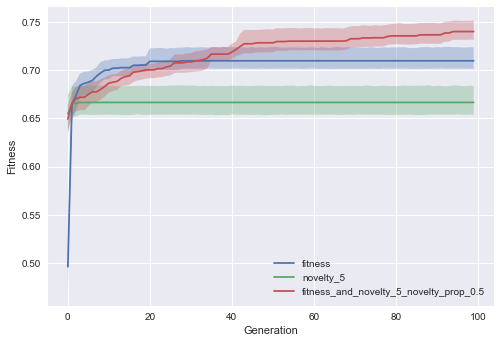

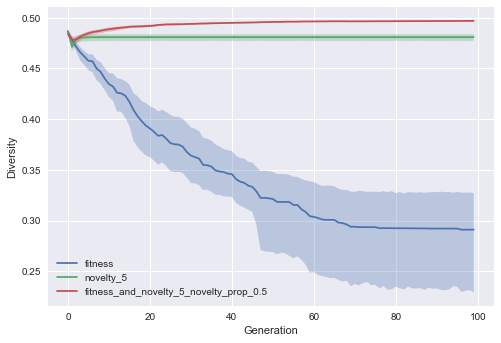

In [28]:
run_names = ["fitness", "novelty_5", "fitness_and_novelty_5_novelty_prop_0.5"]

plot_mean_and_bootstrapped_ci_over_time(input_data = experiment_results, name = run_names, x_label = "Generation", y_label = "Fitness", plot_bootstrap = True)
plot_mean_and_bootstrapped_ci_over_time(input_data = diversity_results, name = run_names, x_label = "Generation", y_label = "Diversity", plot_bootstrap = True)

### Q9: Analysis
What happened (to both fitness and diversity)?  Are you surprised?  Why would this be?

**insert text here**

### Q10:  Balancing Novelty and Fitness
Let's run this again with a different balance of novelty vs. fitness. Please run it with 90% of survivors selected via novelty and just 10% selected via fitness, and also vise versa with just 10% novelty and 90% fitness at each generation.  Which do you expect to work better?

**insert text here**

### Q9b:  Running and Visualization
Let's findout!

In [29]:
num_runs = 20
total_generations = 100
num_elements_to_mutate = 1
bit_string_length = 15
num_parents = 20
num_children = 20

novelty_k = 5
novelty_selection_prop = 0.1
max_archive_length = 100

n = bit_string_length
k = bit_string_length-1

for run_name in ["fitness_and_novelty_5_novelty_prop_0.1"]:
    experiment_results[run_name] = np.zeros((num_runs, total_generations))
    solutions_results[run_name] = np.zeros((num_runs, total_generations, bit_string_length))
    diversity_results[run_name] = np.zeros((num_runs, total_generations))
    for run_num in range(num_runs):
        start_time = time.time()
        landscape = Landscape(n=n, k=k) # generate a random fitness landscape with this level of ruggeddness
        fitness_over_time, solutions_over_time, diversity_over_time = evolutionary_algorithm(fitness_function=landscape.get_fitness, total_generations=total_generations, num_parents=num_parents, num_children=num_children, bit_string_length=bit_string_length, num_elements_to_mutate=1, crossover=False, novelty_k = novelty_k, novelty_selection_prop = novelty_selection_prop, max_archive_length = max_archive_length)   
        experiment_results[run_name][run_num] = fitness_over_time
        solutions_results[run_name][run_num] = solutions_over_time
        diversity_results[run_name][run_num] = diversity_over_time
        print(run_name,run_num,time.time()-start_time,experiment_results[run_name][run_num,-1])

fitness_and_novelty_5_novelty_prop_0.1 0 5.311681270599365 0.7374942467709743
fitness_and_novelty_5_novelty_prop_0.1 1 5.527747869491577 0.7465841511739713
fitness_and_novelty_5_novelty_prop_0.1 2 5.194314479827881 0.7543412564862987
fitness_and_novelty_5_novelty_prop_0.1 3 5.196720838546753 0.6967272814241945
fitness_and_novelty_5_novelty_prop_0.1 4 5.182543992996216 0.7313242043735413
fitness_and_novelty_5_novelty_prop_0.1 5 5.3808934688568115 0.7490782191336202
fitness_and_novelty_5_novelty_prop_0.1 6 5.472676515579224 0.7154748099896612
fitness_and_novelty_5_novelty_prop_0.1 7 5.284702301025391 0.7343605286609761
fitness_and_novelty_5_novelty_prop_0.1 8 5.262497663497925 0.7560391917127726
fitness_and_novelty_5_novelty_prop_0.1 9 5.209930181503296 0.7739377801863015
fitness_and_novelty_5_novelty_prop_0.1 10 5.563517332077026 0.7468337845610378
fitness_and_novelty_5_novelty_prop_0.1 11 5.351389408111572 0.7319586924160225
fitness_and_novelty_5_novelty_prop_0.1 12 5.299304962158203 0

In [30]:
num_runs = 20
total_generations = 100
num_elements_to_mutate = 1
bit_string_length = 15
num_parents = 20
num_children = 20

novelty_k = 5
novelty_selection_prop = 0.9
max_archive_length = 100

n = bit_string_length
k = bit_string_length-1

for run_name in ["fitness_and_novelty_5_novelty_prop_0.9"]:
    experiment_results[run_name] = np.zeros((num_runs, total_generations))
    solutions_results[run_name] = np.zeros((num_runs, total_generations, bit_string_length))
    diversity_results[run_name] = np.zeros((num_runs, total_generations))
    for run_num in range(num_runs):
        start_time = time.time()
        landscape = Landscape(n=n, k=k) # generate a random fitness landscape with this level of ruggeddness
        fitness_over_time, solutions_over_time, diversity_over_time = evolutionary_algorithm(fitness_function=landscape.get_fitness, total_generations=total_generations, num_parents=num_parents, num_children=num_children, bit_string_length=bit_string_length, num_elements_to_mutate=1, crossover=False, novelty_k = novelty_k, novelty_selection_prop = novelty_selection_prop, max_archive_length = max_archive_length)   
        experiment_results[run_name][run_num] = fitness_over_time
        solutions_results[run_name][run_num] = solutions_over_time
        diversity_results[run_name][run_num] = diversity_over_time
        print(run_name,run_num,time.time()-start_time,experiment_results[run_name][run_num,-1])

fitness_and_novelty_5_novelty_prop_0.9 0 2.587428092956543 0.694752240289293
fitness_and_novelty_5_novelty_prop_0.9 1 2.7661447525024414 0.7032646312837757
fitness_and_novelty_5_novelty_prop_0.9 2 2.4483397006988525 0.6777813040773618
fitness_and_novelty_5_novelty_prop_0.9 3 2.46028470993042 0.7646192974485619
fitness_and_novelty_5_novelty_prop_0.9 4 2.4717462062835693 0.7179921249349674
fitness_and_novelty_5_novelty_prop_0.9 5 2.395714521408081 0.7161244013391396
fitness_and_novelty_5_novelty_prop_0.9 6 2.4713292121887207 0.7180240981564715
fitness_and_novelty_5_novelty_prop_0.9 7 2.444277048110962 0.6953454484447222
fitness_and_novelty_5_novelty_prop_0.9 8 2.446225166320801 0.6977425495228934
fitness_and_novelty_5_novelty_prop_0.9 9 2.4134435653686523 0.7086259585237976
fitness_and_novelty_5_novelty_prop_0.9 10 2.56653094291687 0.7173190217928165
fitness_and_novelty_5_novelty_prop_0.9 11 2.7171578407287598 0.7505834980135584
fitness_and_novelty_5_novelty_prop_0.9 12 2.557108163833618

plotting fitness
plotting novelty_5
plotting fitness_and_novelty_5_novelty_prop_0.5
plotting fitness_and_novelty_5_novelty_prop_0.1
plotting fitness_and_novelty_5_novelty_prop_0.9
plotting fitness
plotting novelty_5
plotting fitness_and_novelty_5_novelty_prop_0.5
plotting fitness_and_novelty_5_novelty_prop_0.1
plotting fitness_and_novelty_5_novelty_prop_0.9


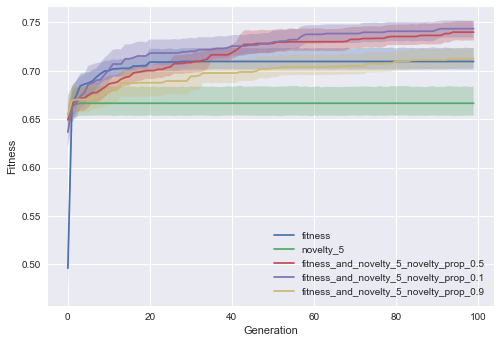

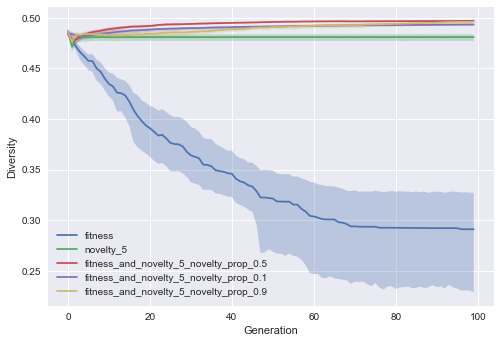

In [31]:
run_names = ["fitness", "novelty_5", "fitness_and_novelty_5_novelty_prop_0.5", "fitness_and_novelty_5_novelty_prop_0.1", "fitness_and_novelty_5_novelty_prop_0.9"]

plot_mean_and_bootstrapped_ci_over_time(input_data = experiment_results, name = run_names, x_label = "Generation", y_label = "Fitness", plot_bootstrap = True)
plot_mean_and_bootstrapped_ci_over_time(input_data = diversity_results, name = run_names, x_label = "Generation", y_label = "Diversity", plot_bootstrap = True)

### Q10: Analysis
Did the experiment turn out the way you thought it would?  Why or why not?  What does this imply about the use of novelty vs. fitness in expoitation vs. exploration?  Do the diveristy plots support this idea?

**insert text here**

### Q11: The Effect of Ruggedness
How much do you think the conclusions you came to above are the result of the particular (maximally rugged) fitness landscape we experiemented with?  What would happen if we used a much smoother landscale (e.g. a NK landscape with `K=0`)

**insert text here**

### Q12: Experiementation
Let's find out!  Please pick your best ratio of novelty vs. fitness selection, and compare it to purely fitness and purely novelty selection on a NK landscale with `K=0`.  Please plot your results.

In [32]:
num_runs = 20
total_generations = 100
num_elements_to_mutate = 1
bit_string_length = 15
num_parents = 20
num_children = 20

novelty_k = 5
novelty_selection_prop = 0.1
max_archive_length = 100

n = bit_string_length
k = 0

for run_name in ["k0_fitness_and_novelty_5_novelty_prop_0.1"]:
    experiment_results[run_name] = np.zeros((num_runs, total_generations))
    solutions_results[run_name] = np.zeros((num_runs, total_generations, bit_string_length))
    diversity_results[run_name] = np.zeros((num_runs, total_generations))
    for run_num in range(num_runs):
        start_time = time.time()
        landscape = Landscape(n=n, k=k) # generate a random fitness landscape with this level of ruggeddness
        fitness_over_time, solutions_over_time, diversity_over_time = evolutionary_algorithm(fitness_function=landscape.get_fitness, total_generations=total_generations, num_parents=num_parents, num_children=num_children, bit_string_length=bit_string_length, num_elements_to_mutate=1, crossover=False, novelty_k = novelty_k, novelty_selection_prop = novelty_selection_prop, max_archive_length = max_archive_length)   
        experiment_results[run_name][run_num] = fitness_over_time
        solutions_results[run_name][run_num] = solutions_over_time
        diversity_results[run_name][run_num] = diversity_over_time
        print(run_name,run_num,time.time()-start_time,experiment_results[run_name][run_num,-1])

k0_fitness_and_novelty_5_novelty_prop_0.1 0 2.0866098403930664 0.6114578434024318
k0_fitness_and_novelty_5_novelty_prop_0.1 1 2.057976722717285 0.6049830768995058
k0_fitness_and_novelty_5_novelty_prop_0.1 2 2.0622665882110596 0.6991934344933711
k0_fitness_and_novelty_5_novelty_prop_0.1 3 2.0484726428985596 0.7299442144708884
k0_fitness_and_novelty_5_novelty_prop_0.1 4 2.0582780838012695 0.6253905285077515
k0_fitness_and_novelty_5_novelty_prop_0.1 5 2.0572350025177 0.5906151413235762
k0_fitness_and_novelty_5_novelty_prop_0.1 6 2.0442545413970947 0.5607096469156496
k0_fitness_and_novelty_5_novelty_prop_0.1 7 2.03383207321167 0.7147102300030377
k0_fitness_and_novelty_5_novelty_prop_0.1 8 2.045901298522949 0.4826306033497635
k0_fitness_and_novelty_5_novelty_prop_0.1 9 2.0979506969451904 0.6987899292907408
k0_fitness_and_novelty_5_novelty_prop_0.1 10 2.1965444087982178 0.7340493074685384
k0_fitness_and_novelty_5_novelty_prop_0.1 11 2.2721574306488037 0.5452868102923686
k0_fitness_and_novelt

In [33]:
num_runs = 20
total_generations = 100
num_elements_to_mutate = 1
bit_string_length = 15
num_parents = 20
num_children = 20

novelty_k = 5
novelty_selection_prop = 0
max_archive_length = 100

n = bit_string_length
k = 0

for run_name in ["k0_fitness"]:
    experiment_results[run_name] = np.zeros((num_runs, total_generations))
    solutions_results[run_name] = np.zeros((num_runs, total_generations, bit_string_length))
    diversity_results[run_name] = np.zeros((num_runs, total_generations))
    for run_num in range(num_runs):
        start_time = time.time()
        landscape = Landscape(n=n, k=k) # generate a random fitness landscape with this level of ruggeddness
        fitness_over_time, solutions_over_time, diversity_over_time = evolutionary_algorithm(fitness_function=landscape.get_fitness, total_generations=total_generations, num_parents=num_parents, num_children=num_children, bit_string_length=bit_string_length, num_elements_to_mutate=1, crossover=False, novelty_k = novelty_k, novelty_selection_prop = novelty_selection_prop, max_archive_length = max_archive_length)   
        experiment_results[run_name][run_num] = fitness_over_time
        solutions_results[run_name][run_num] = solutions_over_time
        diversity_results[run_name][run_num] = diversity_over_time
        print(run_name,run_num,time.time()-start_time,experiment_results[run_name][run_num,-1])

k0_fitness 0 2.0885965824127197 0.7451095145189712
k0_fitness 1 2.1171693801879883 0.618327850880356
k0_fitness 2 2.1987648010253906 0.6265160566538838
k0_fitness 3 2.3109796047210693 0.6349890697637368
k0_fitness 4 2.1746649742126465 0.6493706319267468
k0_fitness 5 2.1319339275360107 0.6025982903299034
k0_fitness 6 2.145479440689087 0.6591989398267712
k0_fitness 7 2.143270254135132 0.6233216792216166
k0_fitness 8 2.119307518005371 0.5946894852290389
k0_fitness 9 2.182398796081543 0.5896013097582785
k0_fitness 10 2.166245698928833 0.7092777368024009
k0_fitness 11 2.152249336242676 0.6932913780555673
k0_fitness 12 2.263469696044922 0.5850472390665505
k0_fitness 13 2.2003865242004395 0.7271757170963244
k0_fitness 14 2.288682699203491 0.6192897640684603
k0_fitness 15 2.462118625640869 0.5504861504636214
k0_fitness 16 2.185906410217285 0.5278807268163744
k0_fitness 17 2.156527042388916 0.7130027279953048
k0_fitness 18 2.156630277633667 0.7872958202499188
k0_fitness 19 2.1338393688201904 0.

In [34]:
num_runs = 20
total_generations = 100
num_elements_to_mutate = 1
bit_string_length = 15
num_parents = 20
num_children = 20

novelty_k = 5
novelty_selection_prop = 1.0
max_archive_length = 100

n = bit_string_length
k = 0

for run_name in ["k0_novelty_5"]:
    experiment_results[run_name] = np.zeros((num_runs, total_generations))
    solutions_results[run_name] = np.zeros((num_runs, total_generations, bit_string_length))
    diversity_results[run_name] = np.zeros((num_runs, total_generations))
    for run_num in range(num_runs):
        start_time = time.time()
        landscape = Landscape(n=n, k=k) # generate a random fitness landscape with this level of ruggeddness
        fitness_over_time, solutions_over_time, diversity_over_time = evolutionary_algorithm(fitness_function=landscape.get_fitness, total_generations=total_generations, num_parents=num_parents, num_children=num_children, bit_string_length=bit_string_length, num_elements_to_mutate=1, crossover=False, novelty_k = novelty_k, novelty_selection_prop = novelty_selection_prop, max_archive_length = max_archive_length)   
        experiment_results[run_name][run_num] = fitness_over_time
        solutions_results[run_name][run_num] = solutions_over_time
        diversity_results[run_name][run_num] = diversity_over_time
        print(run_name,run_num,time.time()-start_time,experiment_results[run_name][run_num,-1])

k0_novelty_5 0 1.134420394897461 0.6984130975244831
k0_novelty_5 1 1.1195240020751953 0.5512367123686833
k0_novelty_5 2 1.1683237552642822 0.6498590801795235
k0_novelty_5 3 1.1849052906036377 0.5546561792603767
k0_novelty_5 4 1.1113462448120117 0.5855159411123945
k0_novelty_5 5 1.103437900543213 0.5803690834053786
k0_novelty_5 6 1.1048150062561035 0.6916144838159191
k0_novelty_5 7 1.1083009243011475 0.6276298913262164
k0_novelty_5 8 1.1145119667053223 0.6173973629868801
k0_novelty_5 9 1.1063175201416016 0.6019600368609607
k0_novelty_5 10 1.1454427242279053 0.6452585711275167
k0_novelty_5 11 1.1957976818084717 0.62355921962181
k0_novelty_5 12 1.1210823059082031 0.5665541626492873
k0_novelty_5 13 1.3057622909545898 0.4473442751423743
k0_novelty_5 14 1.1917636394500732 0.5317083128733643
k0_novelty_5 15 1.099029779434204 0.7111859017442163
k0_novelty_5 16 1.101050853729248 0.6525949911909044
k0_novelty_5 17 1.1072568893432617 0.6114709312465221
k0_novelty_5 18 1.1032435894012451 0.5847450

plotting k0_fitness
plotting k0_novelty_5
plotting k0_fitness_and_novelty_5_novelty_prop_0.1
plotting k0_fitness
plotting k0_novelty_5
plotting k0_fitness_and_novelty_5_novelty_prop_0.1


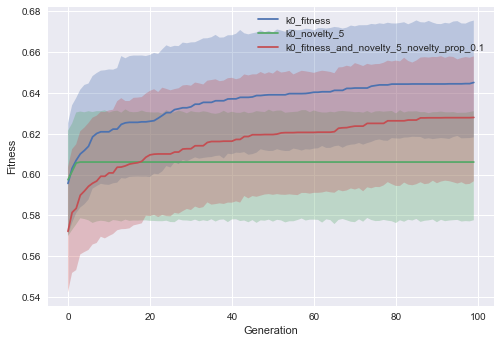

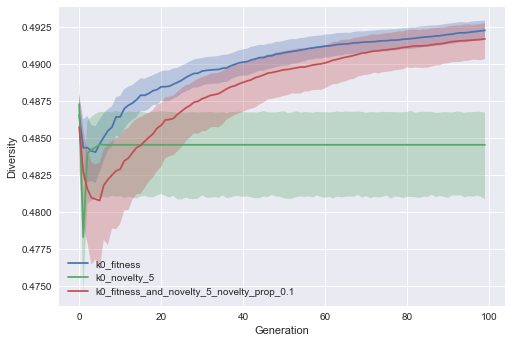

In [35]:
run_names = ["k0_fitness","k0_novelty_5", "k0_fitness_and_novelty_5_novelty_prop_0.1"]

plot_mean_and_bootstrapped_ci_over_time(input_data = experiment_results, name = run_names, x_label = "Generation", y_label = "Fitness", plot_bootstrap = True)
plot_mean_and_bootstrapped_ci_over_time(input_data = diversity_results, name = run_names, x_label = "Generation", y_label = "Diversity", plot_bootstrap = True)

### Q12b:  Analysis
Were you right?  Was novelty, or novelty+fitness helpful?  Was it harmful?  What was the effect on diversity?

**insert text here**

### Q13: Future Work
In this assignment we explored just one (very simple) way to combine novelty and fitness, how else might you want to do this that could be more effetive (and why)?

**insert text here**

### Congratulations, you made it to the end!
Nice work -- and hopefully you're starting to get the hang of these!

Please save this file as a .ipynb, and also download it as a .pdf, uploading **both** to blackboard to complete this assignment.  

For your submission, please make sure that you have renamed this file (and that the resulting pdf follows suit) to replce `[netid]` with your UVM netid.  This will greatly simplify our grading pipeline, and make sure that you receive credit for your work.  

#### Academic Integrity Attribution
During this assignment I collaborated with:

**insert text here**